In [1]:
using FileIO, DelimitedFiles, Random, Statistics, LinearAlgebra, Images, Flux

In [2]:
numMatRow2Image(matRow) = Gray.(reshape(matRow,(30,20)))


numMatRow2Image (generic function with 1 method)

In [186]:
CuCurrent3_HallVoltage_dat_x=[(open("data/exported_data/CuCurrent3_HallVoltage_"*string(i)*".tsv","r") do io readdlm(io) end) for i in 1:6];
CuCurrent3_HallVoltage_X = reduce(vcat,CuCurrent3_HallVoltage_dat_x);
CuCurrent3_HallVoltage_dat_labels=[(open("data/exported_data/CuCurrent3_HallVoltage_"*string(i)*"labels.tsv","r") do io readdlm(io) end) for i in 1:6];


CuCurrent3_HallVoltage_labelled_Y[ind] = -1


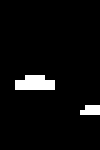

In [187]:
CuCurrent3_HallVoltage_labelled_X = vcat((CuCurrent3_HallVoltage_dat_x[i][Int64.(CuCurrent3_HallVoltage_dat_labels[i][:,1]),:] for i in eachindex(CuCurrent3_HallVoltage_dat_labels))...) #[1,:] |> numMatRow2Image;
CuCurrent3_HallVoltage_labelled_Y = vcat(CuCurrent3_HallVoltage_dat_labels...)[:,2] |> X -> replace(X,"-"=>-1) |> Vector{Int64};

let ind = rand(1:600)
    @show CuCurrent3_HallVoltage_labelled_Y[ind]
    CuCurrent3_HallVoltage_labelled_X[ind,:] |> numMatRow2Image
end


In [235]:
CuCurrent3_HallVoltage_trainIndices = shuffle(eachindex(CuCurrent3_HallVoltage_labelled_Y))[1:800];
CuCurrent3_HallVoltage_train_X = CuCurrent3_HallVoltage_labelled_X[CuCurrent3_HallVoltage_trainIndices,:];
CuCurrent3_HallVoltage_train_Y = CuCurrent3_HallVoltage_labelled_Y[CuCurrent3_HallVoltage_trainIndices];

CuCurrent3_HallVoltage_testIndices = eachindex(CuCurrent3_HallVoltage_labelled_Y) .|> X-> !any(X .∈ CuCurrent3_HallVoltage_trainIndices);
CuCurrent3_HallVoltage_test_X = CuCurrent3_HallVoltage_labelled_X[CuCurrent3_HallVoltage_testIndices,:];
CuCurrent3_HallVoltage_test_Y = CuCurrent3_HallVoltage_labelled_Y[CuCurrent3_HallVoltage_testIndices];


CuCurrent3_HallVoltage_train_Y[ind] = 9


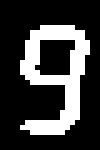

In [236]:
let ind=rand(1:800)
    @show CuCurrent3_HallVoltage_train_Y[ind]
    CuCurrent3_HallVoltage_train_X[ind,:] |> numMatRow2Image;
end

In [405]:
# model_HallVoltage = Chain(
#     Dense(20*30 => 128, relu),
#     BatchNorm(128),
#     Dense(128 => 64, relu),
#     # BatchNorm(64),
#     # Dense(64 => 64, relu),
#     # BatchNorm(64),
#     # Dense(128 => 64, relu),
#     # Dense(64 => 64, relu),
#     Dense(64 => 64, relu),
#     # Dense(64 => 64, relu),
#     # Dense(32 => 32, relu),
#     # BatchNorm(64),
#     # BatchNorm(11),
#     Dense(64 => 32, relu),
#     # Dense(32 => 32, relu),
#     Dense(32 => 11, relu),
#     softmax
# )

model_HallVoltage = Chain(
    Dense(20 * 30 => 100,relu),
    BatchNorm(100),
    Dense(100 => 50,relu),
    Dense(50 => 50,relu),
    Dense(50 => 25,relu),
    Dense(25 => 11,σ),
    softmax
)

Chain(
  Dense(600 => 100, relu),              # 60_100 parameters
  BatchNorm(100),                       # 200 parameters, plus 200
  Dense(100 => 50, relu),               # 5_050 parameters
  Dense(50 => 50, relu),                # 2_550 parameters
  Dense(50 => 25, relu),                # 1_275 parameters
  Dense(25 => 11, σ),                   # 286 parameters
  NNlib.softmax,
)         # Total: 12 trainable arrays, 69_461 parameters,
          # plus 2 non-trainable, 200 parameters, summarysize 272.965 KiB.

In [406]:
# model(CuCurrent3_TransverseCurrent_labelled_X)
loss(mod,dat) = Flux.crossentropy(mod(dat[:data]),dat[:label])
# loss(dat) = Flux.logitcrossentropy(model(dat[:data]),dat[:label])
datLoad = Flux.Data.DataLoader((data=transpose(CuCurrent3_HallVoltage_train_X),label=(Flux.onehotbatch(CuCurrent3_HallVoltage_train_Y,-1:9)));batchsize=1000)

┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 800
└ @ MLUtils /Users/emmyb320/.julia/packages/MLUtils/60cvs/src/dataloader.jl:79


MLUtils.DataLoader{NamedTuple{(:data, :label), Tuple{Transpose{Float64, Matrix{Float64}}, Flux.OneHotArray{UInt32, 11, 1, 2, Vector{UInt32}}}}, Random._GLOBAL_RNG}((data = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], label = Bool[1 0 … 0 0; 0 1 … 1 0; … ; 0 0 … 0 1; 0 0 … 0 0]), 800, 800, true, false, Random._GLOBAL_RNG())

In [407]:
@time @Flux.epochs 100 Flux.train!(X->loss(model_HallVoltage,X), Flux.params(model_HallVoltage), datLoad, ADAM())

  7.254603 seconds (621.61 k allocations: 2.607 GiB, 6.72% gc time, 10.46% compilation time)


┌ Info: Epoch 1
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 2
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 3
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 4
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 5
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 6
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 7
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 8
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 9
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 10
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 11
└ @ Main /Users/emmyb320/.julia/packages/F

In [408]:
accuracY(mod,X,Y) = (Flux.onecold((mod)(X|>transpose),-1:9) .== Y) |> mean;
accuracY(model_HallVoltage,CuCurrent3_HallVoltage_train_X,CuCurrent3_HallVoltage_train_Y)

1.0

In [409]:
accuracY(model_HallVoltage,CuCurrent3_HallVoltage_test_X,CuCurrent3_HallVoltage_test_Y)


0.9971428571428571

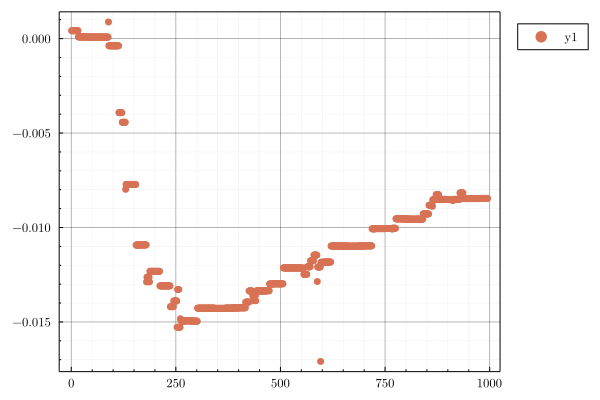

In [410]:
signs = 1 .+ 2 .* (CuCurrent3_HallVoltage_dat_x .|> X->Flux.onecold(model_HallVoltage(transpose(X)),-1:9))[1]
readValueswoSign = [(CuCurrent3_HallVoltage_dat_x[2:6] .|> X->Flux.onecold(model_HallVoltage(transpose(X)),-1:9))[i] .* [0.1, 0.01, 0.001, 0.0001, 0.00001][i] for i in 1:5] |> X -> reduce(hcat,X) |> X -> sum(X,dims=2)
readValues_HallVoltage = [signs[i] .* vec(readValueswoSign)[i] for i in eachindex(signs)]
scatter(readValues_HallVoltage)

# Trans current:


CuCurrent3_TransverseCurrent_labelled_Y[ind] = 1


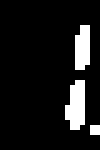

In [315]:
CuCurrent3_TransverseCurrent_dat_x=[(open("data/exported_data/CuCurrent3_TransverseCurrent_"*string(i)*".tsv","r") do io readdlm(io) end) for i in 1:4];
CuCurrent3_TransverseCurrent_X = reduce(vcat,CuCurrent3_TransverseCurrent_dat_x);
CuCurrent3_TransverseCurrent_dat_labels=[(open("data/exported_data/CuCurrent3_TransverseCurrent_"*string(i)*"labels.tsv","r") do io readdlm(io) end) for i in 1:4];
CuCurrent3_TransverseCurrent_labelled_X = vcat((CuCurrent3_TransverseCurrent_dat_x[i][Int64.(CuCurrent3_TransverseCurrent_dat_labels[i][:,1]),:] for i in eachindex(CuCurrent3_TransverseCurrent_dat_labels))...) #[1,:] |> numMatRow2Image;
CuCurrent3_TransverseCurrent_labelled_Y = vcat(CuCurrent3_TransverseCurrent_dat_labels...)[:,2] |> X -> replace(X,"-"=>-1) |> Vector{Int64};
let ind = rand(1:1000)
    @show CuCurrent3_TransverseCurrent_labelled_Y[ind]
    CuCurrent3_TransverseCurrent_labelled_X[ind,:] |> numMatRow2Image
end



In [317]:
CuCurrent3_TransverseCurrent_trainIndices = shuffle(eachindex(CuCurrent3_TransverseCurrent_labelled_Y))[1:800];
CuCurrent3_TransverseCurrent_train_X = CuCurrent3_TransverseCurrent_labelled_X[CuCurrent3_TransverseCurrent_trainIndices,:];
CuCurrent3_TransverseCurrent_train_Y = CuCurrent3_TransverseCurrent_labelled_Y[CuCurrent3_TransverseCurrent_trainIndices];

CuCurrent3_TransverseCurrent_testIndices = eachindex(CuCurrent3_TransverseCurrent_labelled_Y) .|> X-> !any(X .∈ CuCurrent3_TransverseCurrent_trainIndices);
CuCurrent3_TransverseCurrent_test_X = CuCurrent3_TransverseCurrent_labelled_X[CuCurrent3_TransverseCurrent_testIndices,:];
CuCurrent3_TransverseCurrent_test_Y = CuCurrent3_TransverseCurrent_labelled_Y[CuCurrent3_TransverseCurrent_testIndices];


CuCurrent3_TransverseCurrent_train_Y[ind] = 0


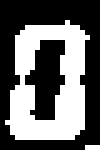

In [319]:
let ind=rand(1:800)
    @show CuCurrent3_TransverseCurrent_train_Y[ind]
    CuCurrent3_TransverseCurrent_train_X[ind,:] |> numMatRow2Image;
end

CuCurrent3_TransverseCurrent_test_Y[ind] = 8


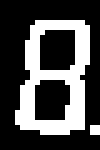

In [320]:
let ind=rand(1:100)
    @show CuCurrent3_TransverseCurrent_test_Y[ind]
    CuCurrent3_TransverseCurrent_test_X[ind,:] |> numMatRow2Image;
end

In [395]:
# model = Chain(
#     # Dense(20 * 30 => 256,relu),
#     Dense(20 * 30 => 512,relu),
#     BatchNorm(512),
#     Dense(512 => 128,relu),
#     # Dense(512 => 256,relu),
#     # Dense(256 => 64,relu),
#     Dense(128 => 64,relu),
#     BatchNorm(64),
#     # Dense(64 => 64,relu),
#     # Dense(128 => 128,relu),
#     # Dense(64 => 64,relu),
#     Dense(64 => 64,relu),
#     Dense(64 => 11,relu),
#     softmax
# )

# model = Chain(
#     Dense(20*30 => 64, relu),
#     BatchNorm(64),
#     # Dense(128 => 64, relu),
#     # BatchNorm(64),
#     # Dense(64 => 64, relu),
#     # BatchNorm(64),
#     # Dense(128 => 64, relu),
#     Dense(64 => 64, relu),
#     Dense(64 => 64, relu),
#     # Dense(64 => 64, relu),
#     # Dense(32 => 32, relu),
#     BatchNorm(64),
#     # BatchNorm(11),
#     Dense(64 => 32, relu),
#     # Dense(32 => 32, relu),
#     Dense(32 => 11, relu),
#     softmax
# )

# model = Chain(
#     # Dense(20*30 => 64, relu),
#     Dense(20*30 => 64, relu),
#     # Dense(20*30 => 64, relu),
#     # BatchNorm(64),
#     Dense(64 => 64, relu),
#     BatchNorm(64),
#     # Dense(64 => 64, relu),
#     # BatchNorm(64),
#     Dense(64 => 64, relu),
#     Dense(64 => 64, relu),
#     # Dense(32 => 32, relu),
#     # BatchNorm(64),
#     # BatchNorm(11),
#     Dense(64 => 32, relu),
#     Dense(32 => 11, relu),
#     softmax
# )

model = Chain(
    Dense(20 * 30 => 100,relu),
    BatchNorm(100)
    Dense(100 => 50,relu),
    Dense(50 => 50,relu),
    Dense(50 => 25,relu),
    Dense(25 => 11,σ),
    softmax
)


LoadError: syntax: missing comma or ) in argument list

In [396]:
# model(CuCurrent3_TransverseCurrent_labelled_X)
loss(dat) = Flux.crossentropy(model(dat[:data]),dat[:label])
# loss(dat) = Flux.logitcrossentropy(model(dat[:data]),dat[:label])
datLoad = Flux.Data.DataLoader((data=transpose(CuCurrent3_TransverseCurrent_train_X),label=(Flux.onehotbatch(CuCurrent3_TransverseCurrent_train_Y,-1:9)));batchsize=1000)

┌ Warning: Number of observations less than batchsize, decreasing the batchsize to 800
└ @ MLUtils /Users/emmyb320/.julia/packages/MLUtils/60cvs/src/dataloader.jl:79


MLUtils.DataLoader{NamedTuple{(:data, :label), Tuple{Transpose{Float64, Matrix{Float64}}, Flux.OneHotArray{UInt32, 11, 1, 2, Vector{UInt32}}}}, Random._GLOBAL_RNG}((data = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], label = Bool[0 0 … 0 0; 1 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0]), 800, 800, true, false, Random._GLOBAL_RNG())

In [397]:
@time @Flux.epochs 500 Flux.train!(loss, Flux.params(model), datLoad, ADAM())

┌ Info: Epoch 1
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 2
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 3
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 4
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 5
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 6
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 7
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 8
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 9
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 10
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 11
└ @ Main /Users/emmyb320/.julia/packages/F

 34.155473 seconds (322.12 k allocations: 8.121 GiB, 4.84% gc time, 0.24% compilation time)


┌ Info: Epoch 417
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 418
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 419
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 420
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 421
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 422
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 423
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 424
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 425
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 426
└ @ Main /Users/emmyb320/.julia/packages/Flux/18YZE/src/optimise/train.jl:153
┌ Info: Epoch 427
└ @ Main /Users/emmyb3

In [398]:
accuracY(X,Y) = (Flux.onecold((model)(X|>transpose),-1:9) .== Y) |> mean;
accuracY(CuCurrent3_TransverseCurrent_train_X,CuCurrent3_TransverseCurrent_train_Y)

0.99875

In [400]:
accuracY(CuCurrent3_TransverseCurrent_test_X,CuCurrent3_TransverseCurrent_test_Y)


0.964824120603015

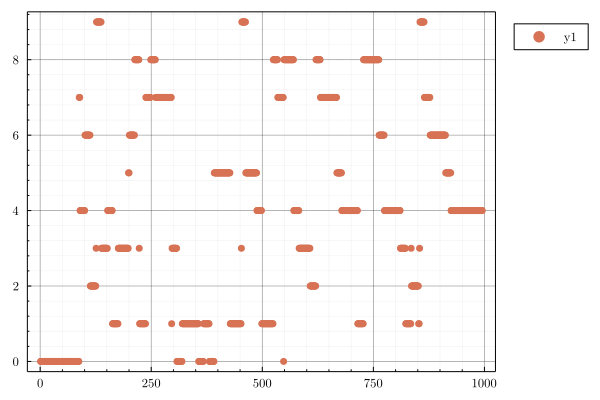

In [401]:
using Plots; theme(:dao)
meow=Flux.onecold(model(transpose(CuCurrent3_TransverseCurrent_dat_x[3])),-1:9);
scatter(meow)

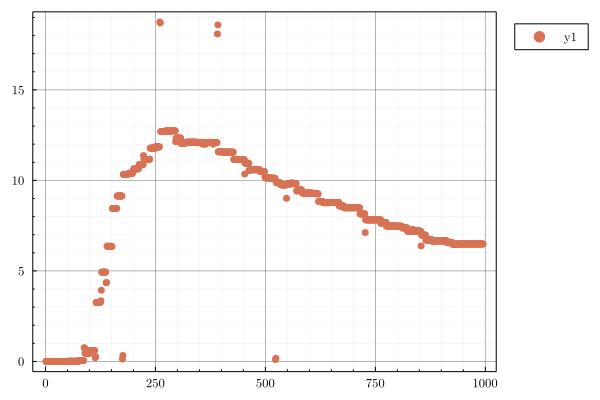

In [402]:
readValues = [(CuCurrent3_TransverseCurrent_dat_x .|> X->Flux.onecold(model(transpose(X)),-1:9))[i] .* [10, 1, 0.1, 0.01][i] for i in 1:4] |> X -> reduce(hcat,X) |> X -> sum(X,dims=2);
scatter(readValues)

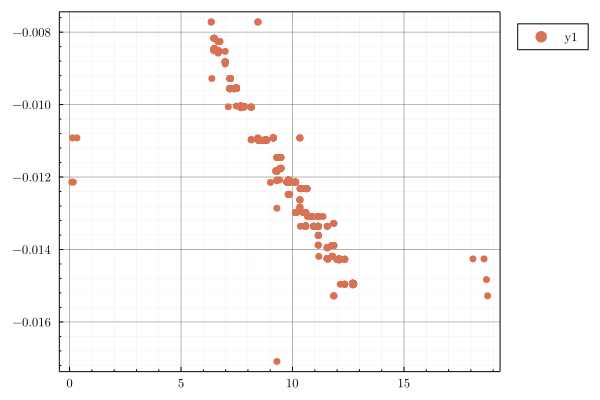

In [411]:
scatter(readValues[150:end], readValues_HallVoltage[150:end])